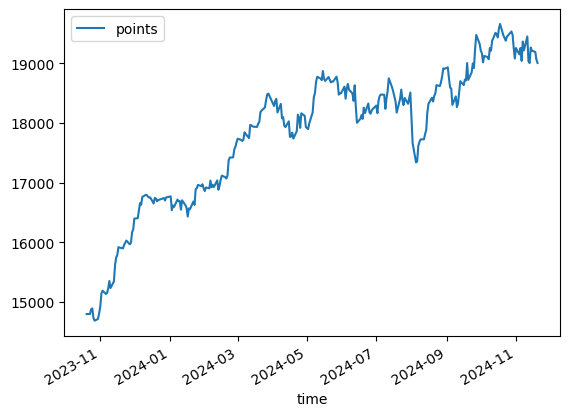

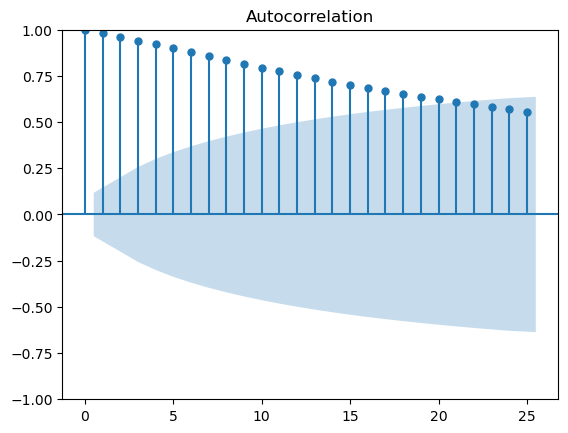

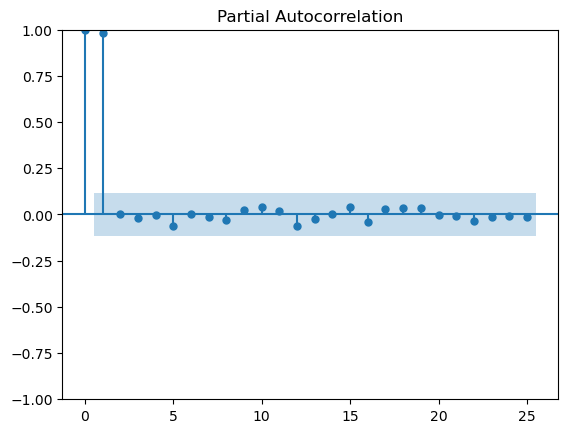

In [135]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

# Load the CSV file
data = pd.read_csv('DAX_Historical_Data_2_year_daily.csv')

# Extract the time and price series
time = pd.to_datetime(data.iloc[:, 0])  # Assuming first column is 'time'
prices = data.iloc[:, 1].replace(',', '', regex=True).astype(float)  # Remove commas and convert to float


# Create a DataFrame with the time and prices
time_series_df = pd.DataFrame({'time': time, 'points': prices})
time_series_df.set_index('time', inplace=True)

def plot_series(series):
    # Plot the time series using Plotly
    series.plot()
    
    plot_acf(series)
    plot_pacf(series)
plot_series(time_series_df)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [136]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(0.5298884097617311,
 0.9857537705335744,
 0,
 277,
 {'1%': -3.4541800885158525,
  '5%': -2.872031361137725,
  '10%': -2.5723603999791473},
 3276.7070388152842)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

Optimal lambda:  6.383971806989063


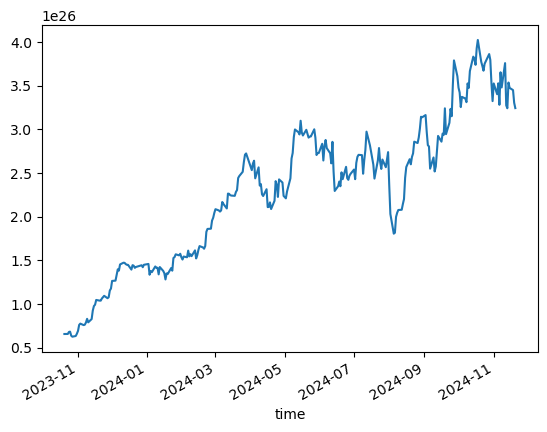

In [137]:
from scipy import stats


# Apply Box-Cox transformation and estimate lambda
transformed_prices, lambda_est = stats.boxcox(time_series_df["points"])

# Store the transformed values back into the DataFrame
time_series_df['boxcox_points'] = transformed_prices

time_series_df['boxcox_points'].plot()

print("Optimal lambda: ", lambda_est)

Differentiate and see when stationarity tests become positive

In [141]:
alpha = 0.05

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['points'] # todo possible bug, try with_: pd.DataFrame(np.random.random(100))#np.exp(time_series_df['boxcox_points'])
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff()

    # Add the differenced series to the DataFrame
    time_series_df[f'diff_prices_{differencing_count}'] = current_series
    print("defferentiation")
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





defferentiation
After 1 differencing(s), the ADF p-value is: 4.258559984813102e-30
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

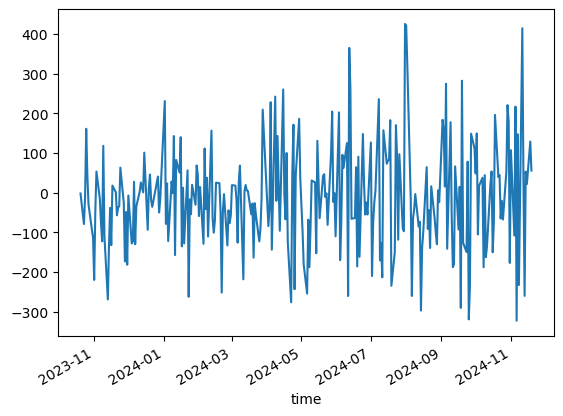

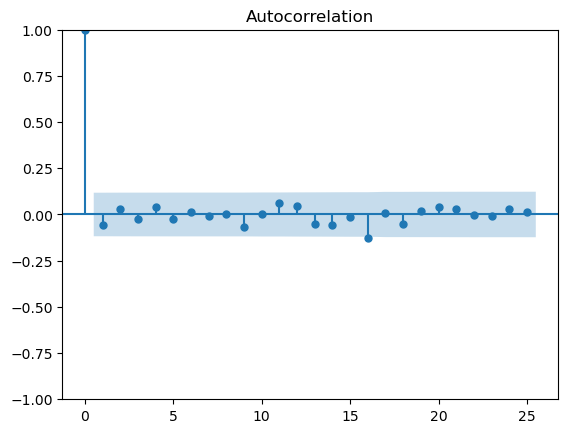

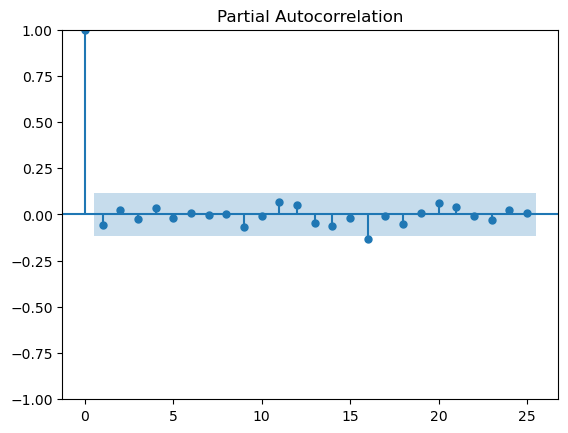

In [142]:
plot_series(time_series_df[f'diff_prices_{differencing_count}'].dropna())


Print significant auto and partial autocorelations

In [140]:
print(st.acf(time_series_df[f'diff_prices_{differencing_count}'].dropna(), qstat=True))

(array([ 1.        , -0.11367946,  0.02099478, -0.03730325,  0.02373357,
       -0.02188219,  0.01158286, -0.02653056, -0.01228128, -0.05440075,
       -0.00711533,  0.04871737,  0.02827268, -0.07065329, -0.03717388,
       -0.01640016, -0.11709249, -0.00617295, -0.06961223,  0.01411908,
        0.06269392,  0.04193421,  0.0080593 , -0.030279  ,  0.01196649]), array([ 3.61858616,  3.7424584 ,  4.13494665,  4.29440506,  4.43045449,
        4.46871459,  4.67018585,  4.71351886,  5.56693129,  5.58158553,
        6.27114216,  6.50425807,  7.96557622,  8.37164903,  8.45098656,
       12.51075739, 12.5220839 , 13.96804048, 14.02775462, 15.20971181,
       15.74057284, 15.76025799, 16.03921245, 16.08295427]), array([0.05713741, 0.15393433, 0.2472562 , 0.36762622, 0.48924196,
       0.61351617, 0.7001389 , 0.78771066, 0.7823563 , 0.84910714,
       0.85467405, 0.88856362, 0.84583566, 0.86907962, 0.90443311,
       0.708136  , 0.76754524, 0.73117228, 0.78207097, 0.76428469,
       0.7840456 , 0